[Overview]

1. 라이브러리 설정
2. HyperParameter 설정
3. GPU 설정
4. Data 준비(Data 불러오기, Data 전처리, Tokenizing)
5. 모델 설계
6. 모델 훈련 (Training)
7. 모델 검증 (Testing)

In [4]:
# 1. 라이브러리 설정
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import DataLoader 
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

try:
    %tensorflow_version 2.x
except Exception:
    pass


import tensorflow as tf 
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
print(f'Pytorch version: {torch.__version__}')
import os

Pytorch version: 2.0.1


In [5]:
# 2. HyperParameter
batch_size = 64
lr = 1e-4
epochs = 10
model_name = "RNN"
vocab_length = 7000
num_layers = 3
hidden_size = 256
num_classes = 2
embedding_size = 256
dropout = 0.1


#seed
random_seed = 9712
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
print(torch.randn(1, 3))

# 3. GPU 설정
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# 4. Data 준비
train_data = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", delimiter='\t').dropna()
test_data = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", delimiter='\t').dropna()
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))
print(train_data)
# 깃허브 내에 train, test data 가져오는건데, read_csv 기능 중 delimiter. dropna를 모르겠음


tensor([[0.3936, 0.5584, 0.9692]])
훈련용 리뷰 개수 : 149995
테스트용 리뷰 개수 : 49997
              id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[149995 rows x 3 columns]


In [6]:
# 4-1. text, label 나누기.
train_text, train_label = train_data.iloc[:, 1], train_data.iloc[:, 2]
# train_text, train_label = train_data.iloc[:, 1], train_data.iloc[:, 2]
test_text, test_label = test_data.iloc[:, 1], test_data.iloc[:, 2]
# 3개의 column 으로 나뉘는데, 그중 2번째, 3번째 추출
# df.iloc[행 인덱스,. 열 인덱스], 행을 전체 가져오고, 열은 몇개만 추출
# column 2번째는 text, 3번째는 label

print("[Text]")
print(train_text)
print()
print("[Label]")
print(train_label)

#pd.read_csv의 iloc 기능을 가져오는 것 같음 

[Text]
0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 149995, dtype: object

[Label]
0         0
1         1
2         0
3         0
4         1
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 149995, dtype: int64


문장: 아 더빙.. 진짜 짜증나네요 목소리
문장: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
텍스트 정제 후: 아 더빙 진짜 짜증나네요 목소리
띄어쓰기 단위로 분리 후: ['아', '더빙', '진짜', '짜증나네요', '목소리']
None
Tokenizer 후: [26, 898, 8, 6750, 1094]


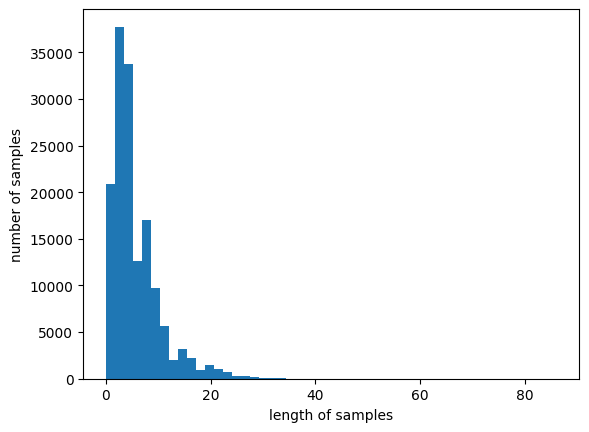

Padding 후: [  26  898    8 6750 1094    0    0    0    0    0    0    0    0    0
    0]


In [14]:
# 4-2. Tokenizing
# Tokenizing을 위한 text 정제 작업
import re
def clean_str(string): #clean_str, string는 임의 변수
    # From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string) 
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)
    return string.lower()
# 왜 이러는 지 이해 못하겠음. 전처리 단계 확인해보도록 해야겠음
# 단어 끊는 기준인거 같은데, import re가 무슨 기능이고, sub가 무슨 내용인지 모르겠음.

print("문장:", train_text[0])
print("문장:", train_text[1])

#텍스트 정제 작업
train_x = [clean_str(x) for x in train_text]
test_x = [clean_str(x) for x in test_text]
print("텍스트 정제 후:", train_x[0])

#문장을 띄어쓰기 단위로 분리
train_x = [x.split(' ') for x in train_x]
test_x = [x.split(' ') for x in test_x]
print("띄어쓰기 단위로 분리 후:", train_x[0])
# train text의 x를 반복하여서 clean str안에 넣어 정리할 것을 train_x로 말함.
# split이 분리함.

#Tokenizer 만들기
tokenizer = Tokenizer(num_words = vocab_length) 
tokenizer.fit_on_texts(train_x)
# 위에서 토크나이저 클래스 불러와서 사용. 각 문장의 최대 길이를 정의. num_words는 tokenizer에 담겨져 있다.
# 토크나이저 기능 중 fit_on_texts를 사용하는데 그 안에 train_x를 담는다.(아마 함수 기능)
# 케라스 기능으로 나오는 fit_on_texts이다. 각 단어를 빈도수 순으로 정렬 후, 빈도수가 높은 순서대로 차례대로 낮은 숫자부터 부여 방법
# 그래서 출력해서 보여준다.

#Tokenizer 
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)
print("Tokenizer 후:", train_x[0])
# 다시 토크나이저 기능 중의 texts to sequences 기능을 사용해서 정리한다.
# split 대로 풀고, 다시 문장으로 정리.

# max len 
plt.hist([len(review) for review in train_x], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 이건 그래프 출력하는 건데... train_x 안의 review라는 임의 내용을 담아서 정리. hist의 bins는 뭔가
# 한 샘플의 길이마다 개수 보여줌

#Padding
train_x = pad_sequences(train_x, padding='post',maxlen=15)
test_x = pad_sequences(test_x, padding='post', maxlen=15) #훈련 데이터 중 max_length로 padding된다. 
print("Padding 후:", train_x[0])
# train_x 를 다시 pad_sequences 기능으로 padding을 걸어준다. 시퀀스 길이는 maxlen 15개이다.
# 패딩을 뒤에다 걸고 싶으면 post 넣어준다.

In [8]:
print("26:", tokenizer.index_word[26])
print("898:", tokenizer.index_word[898])
print("8:", tokenizer.index_word[8])
print("1094:", tokenizer.index_word[1094])

26: 아
898: 더빙
8: 진짜
1094: 목소리


In [9]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels
    def __getitem__(self, idx):
        x = self.datas[idx]
        y = self.labels[idx]
        return x, y
    def __len__(self):
        return len(self.labels)

train_y = np.array(train_label)
train_dataset = MyDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True )

test_y = np.array(test_label)
test_dataset = MyDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)


print(f"[Dataset] train: {len(train_dataset)}, test: {len(test_dataset)}")
print(f"[DataLoader] train: {len(train_dataloader)}, test: {len(test_dataloader)}")

[Dataset] train: 149995, test: 49997
[DataLoader] train: 2344, test: 49997


In [10]:
# 5. Model 설계
class RNN(nn.Module):
    def __init__(self, vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout):  # 나중에 내가 RNN 모델 부를때 쓰는 변수들을 
        super(RNN, self).__init__()
        print("Model=RNN")
        self.embedding_layer = nn.Embedding(vocab_length, embedding_size, padding_idx =0) #입력 문장을 벡터화 시킨다 
        self.rnn = nn.RNN(input_size=embedding_size,  hidden_size=hidden_size, num_layers=num_layers,  batch_first= True,  dropout=dropout)
        self.classifier_linear = nn.Linear(hidden_size, num_classes)

    
    def forward(self, x):
        embed = self.embedding_layer(x)
        rnn_output, _ = self.rnn(embed)
        cut_output = rnn_output[:, -1, :]
        cla_output = self.classifier_linear(cut_output)
        return cla_output
        """
        x = (batch_size, max_len)
        embed = (batch_size, max_len, embedding_size)
        rnn_output =  (batch_size, max_len, hidden_size)
        cut_output = (batch_size, hidden_size)
        cla_output =  (batch_size, num_classes)
        """

class LSTM(nn.Module):
    def __init__(self, vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout):  
        super(LSTM, self).__init__()
        print("Model=LSTM")
        self.embedding_layer = nn.Embedding(vocab_length, hidden_size, padding_idx =0) 
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers,  batch_first= True,  dropout=dropout)
        self.classifier_linear = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        embed = self.embedding_layer(x)
        lstm_output, _ = self.lstm(embed)
        cut_output = lstm_output[:, -1, :]
        cla_output = self.classifier_linear(cut_output)
        return cla_output
        """
        x = (batch_size, max_len)
        embed = (batch_size, max_len, embedding_size)
        lstm_output =  (batch_size, max_len, hidden_size)
        cut_output = (batch_size, hidden_size)
        cla_output =  (batch_size, num_classes)
        """


class GRU(nn.Module):
    def __init__(self, vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout):  
        super(GRU, self).__init__()
        print("Model=GRU")
        self.embedding_layer = nn.Embedding(vocab_length, hidden_size, padding_idx =0) 
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers,  batch_first= True,  dropout=dropout)
        self.classifier_linear = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        embed = self.embedding_layer(x)
        lstm_output, _ = self.gru(embed)
        cut_output = lstm_output[:, -1, :]
        cla_output = self.classifier_linear(cut_output)
        return cla_output
        """
        x = (batch_size, max_len)
        embed = (batch_size, max_len, embedding_size)
        lstm_output =  (batch_size, max_len, hidden_size)
        cut_output = (batch_size, hidden_size)
        cla_output =  (batch_size, num_classes)
        """


In [11]:
if model_name == "RNN":
    model = RNN(vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout)
elif model_name == "LSTM":
    model = LSTM(vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout)
elif model_name == "GRU":
    model = GRU(vocab_length, embedding_size, hidden_size, num_layers, num_classes, dropout)

model = model.to(device)

Model=RNN


In [12]:
# 6. Model Training

loss_fnc = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
tot_train_loss  = []
for e in range(1, epochs+1):
    train_loss = 0.0
    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data) #(batch_size, 2)
        loss = loss_fnc(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    tot_train_loss.append(train_loss/len(train_dataloader))
    print(f"epoch:{e}/{epochs} loss: {train_loss/len(train_dataloader):.9f}")

# 7. Model Testing

with torch.no_grad():
    model.eval()
    test_acc = 0.0
    for data, label in tqdm(test_dataloader):
        data = data.to(device)
        label = label.to(device)
        output = model(data) #(batch, 2)
        preds = torch.argmax(output, dim=1)
        test_acc += preds.eq(label).sum().item()
    print(f"test acc: {test_acc/len(test_dataloader.dataset)*100}%")

# 기존과 동일    

  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:1/10 loss: 0.596629024


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:2/10 loss: 0.516893309


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:3/10 loss: 0.474280437


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:4/10 loss: 0.444666003


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:5/10 loss: 0.423796289


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:6/10 loss: 0.408085572


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:7/10 loss: 0.393218837


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:8/10 loss: 0.381268196


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:9/10 loss: 0.370143506


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch:10/10 loss: 0.360334257


  0%|          | 0/49997 [00:00<?, ?it/s]

test acc: 78.63871832309938%
